In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

from models.conv_nets import make_convNet 
from utils.train_utils import train_conv_nets
from utils.visualizations import plot_loss_from_file

# keeps tensorflow from using all available GPU memory when a model is initialized.
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
train_conv_nets(
    data_set='cifar10',
    convnet_depth=7,
    convnet_widths=[1 + i for i in range(16)],
    label_noise_as_int=0
)

STARTING TRAINING: conv_net_depth_7_width_1, Alpha: 1
Epoch: 0000, Total Run Time: 00:00:11 - Loss: 1.9154e+00, Accuracy: 0.307, Test Loss: 2.0462e+00, Test Accuracy: 0.297
Epoch: 0025, Total Run Time: 00:02:22 - Loss: 9.1404e-01, Accuracy: 0.678, Test Loss: 1.2301e+00, Test Accuracy: 0.590
Epoch: 0050, Total Run Time: 00:04:32 - Loss: 8.2478e-01, Accuracy: 0.708, Test Loss: 1.0734e+00, Test Accuracy: 0.629
Epoch: 0075, Total Run Time: 00:06:40 - Loss: 7.8747e-01, Accuracy: 0.722, Test Loss: 1.0544e+00, Test Accuracy: 0.649
Epoch: 0100, Total Run Time: 00:08:49 - Loss: 7.7038e-01, Accuracy: 0.727, Test Loss: 1.0850e+00, Test Accuracy: 0.641
Epoch: 0125, Total Run Time: 00:10:58 - Loss: 7.5441e-01, Accuracy: 0.734, Test Loss: 1.0142e+00, Test Accuracy: 0.662
Epoch: 0150, Total Run Time: 00:13:08 - Loss: 7.4421e-01, Accuracy: 0.738, Test Loss: 1.0687e+00, Test Accuracy: 0.648
Epoch: 0175, Total Run Time: 00:15:17 - Loss: 7.3586e-01, Accuracy: 0.741, Test Loss: 1.0837e+00, Test Accuracy: 

In [2]:
batch_size=128
n_epochs = 500_000 // (50_000 // 128) # total number desirec SGD steps / number batches per epoch

label_noise_int = 0
label_noise = label_noise_int / 100


# load the Cifar 10 data set
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
image_shape = x_train[0].shape

# apply label noise to the data set
random_idx = np.random.choice(x_train.shape[0], int(label_noise*x_train.shape[0]))
rand_labels = np.random.randint(low=y_train.min(), high=y_train.max(), size=len(random_idx))
y_train[random_idx] = np.expand_dims(rand_labels, axis=1)

model_histories = {}
convnet_widths = [1 + i for i in range(16)] 
convnet_depth = 7

# Paths to save model weights and 
model_weights_paths = f'trained_model_weights/conv_nets_depth_{convnet_depth}_{label_noise_int}pct_noise/'
data_save_path = 'experimental_results/conv_nets_'

for width in convnet_widths:
    # Depth 7 Conv Net using default Kaiming Uniform Initialization.
    conv_net, model_id = make_convNet(image_shape, depth=convnet_depth, init_channels=width)

    conv_net.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=inverse_squareroot_lr()),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model_timer = timer()
    
    print(f'STARTING TRAINING: {model_id}')
    history = conv_net.fit(
        x=x_train, y=y_train, 
        validation_data=(x_test, y_test),
        epochs=n_epochs,
        batch_size=batch_size,
        verbose=0, 
        callbacks = [model_timer]
    )
    print(f'FINISHED TRAINING: {model_id}')    
    
    # add results to dictionary and store the resulting model weights.
    model_histories[model_id] = history
    history.model.save_weights(model_weights_paths+model_id)
    
    # clear GPU of prior model to decrease training times.
    tf.keras.backend.clear_session()
    
    
# store all the results in a pickle file for later graphing and analysis.
depth_7_metrics = {} 

for m_id, history in model_histories.items():
    depth_7_metrics[m_id] = history.history
    
pkl.dump(depth_7_metrics, open(data_save_path + f'depth_{convnet_depth}_{label_noise_int}pct_noise.pkl', 'wb'))

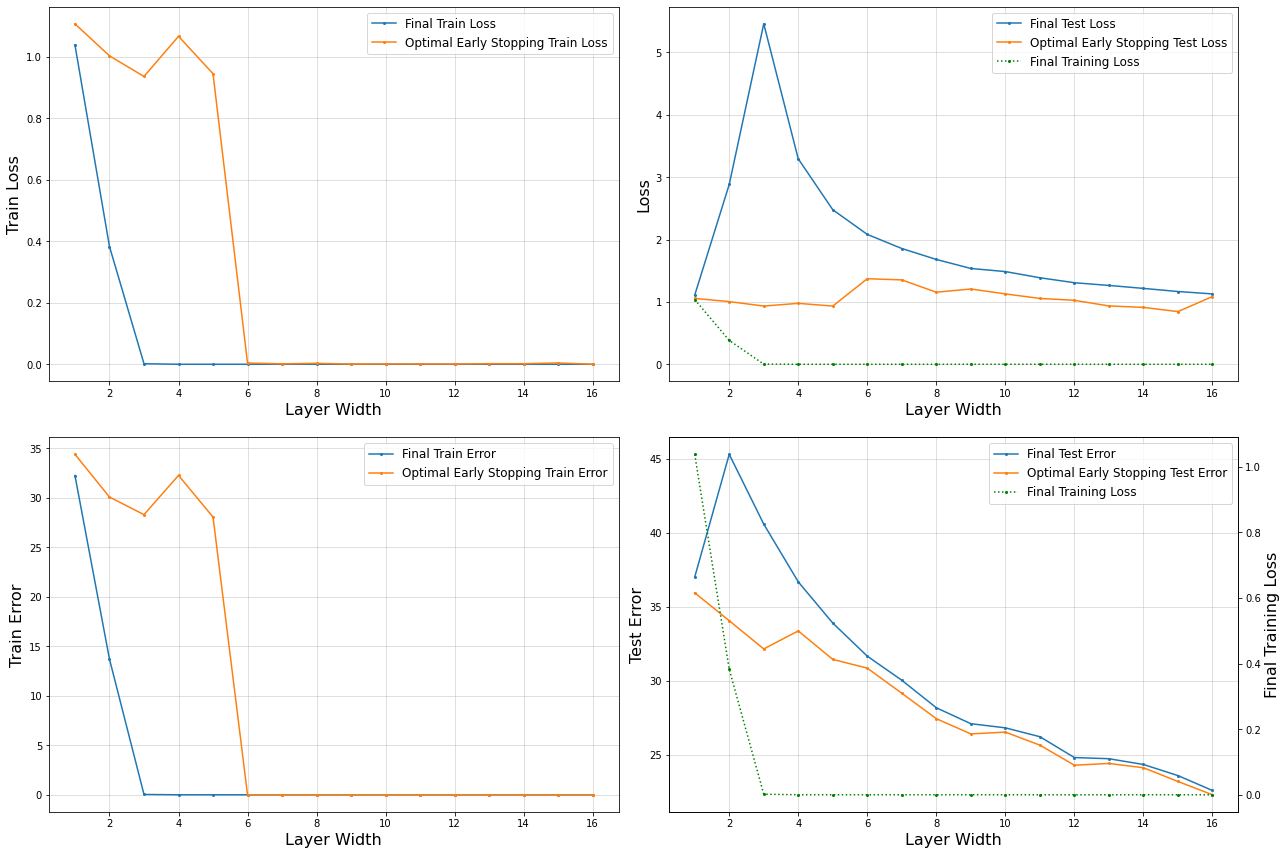

In [4]:
plot_path = f'experimental_results_cifar10/conv_nets_depth_7_10pct_noise_alpha_1.pkl'
plot_loss_from_file(plot_path)

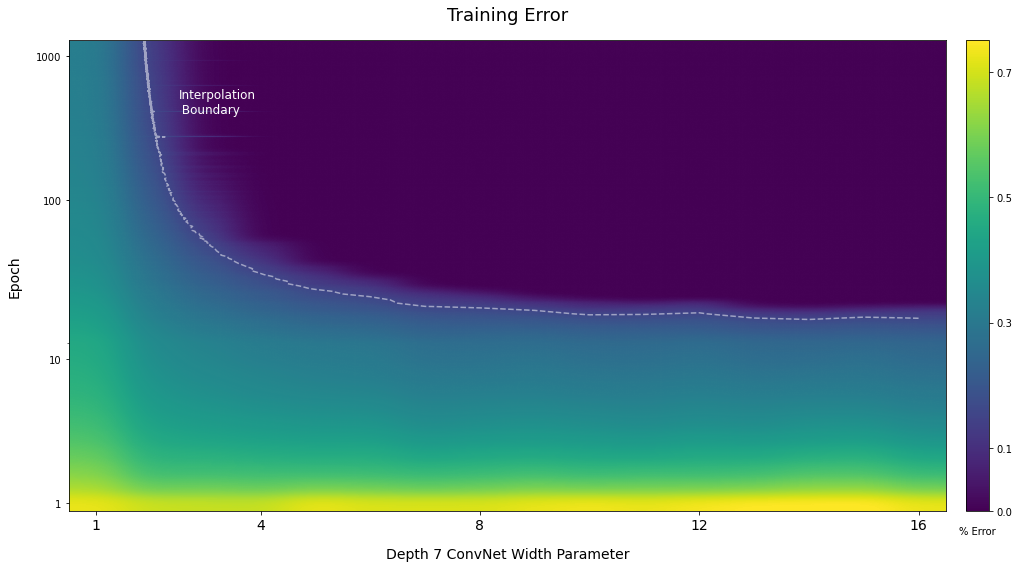

In [341]:
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib 

fig = plt.figure(figsize=(15, 8))
ax = fig.gca()

M = 1 - train_accuracy + 1e-15
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=0.75)
im = ax.imshow(M.T, aspect='auto',  origin='lower', norm=norm, interpolation='gaussian') 

# set axis labels and title
ax.set_xlabel('Depth 7 ConvNet Width Parameter', fontsize=14, labelpad=15)
ax.set_ylabel('Epoch', fontsize=14, labelpad=15)
ax.set_title('Training Error', fontsize=18, pad=20)

# set x axis ticks (not that there is an offset of 1 since the array is 0 indexed)
x_idx = [0, 3, 7, 11, 15]
x_vals = x_idx
x_labs = ['%d' % (n+1) for n in x_idx]
ax.set_xticks(x_idx)
ax.set_xticklabels(x_labs, fontsize=14)

# set y ticks and adjust scale
ax.set_yscale('symlog', linthresh=10)
ax.set_yticks([i-1 for i in [1, 10, 100, 1000]])
ax.set_yticklabels([1, 10, 100, 1000])

# Colorbar
ticks = [0.0, 0.1, 0.3, 0.5, 0.7]
cbar = fig.colorbar(im, pad=0.02, ticks=ticks, fraction=0.1)
cbar.ax.get_xaxis().labelpad = 15
cbar.ax.set_xlabel('% Error')

# add interpolation point contour and label
ax.contour(M.T, levels=[0.155], colors='white', linestyles='dashed', linewidths=1.5, alpha=0.5)
ax.annotate('Interpolation\n Boundary', (0.175, 0.8), c='w', fontsize=12, xycoords='figure fraction')

plt.tight_layout()
plt.show()

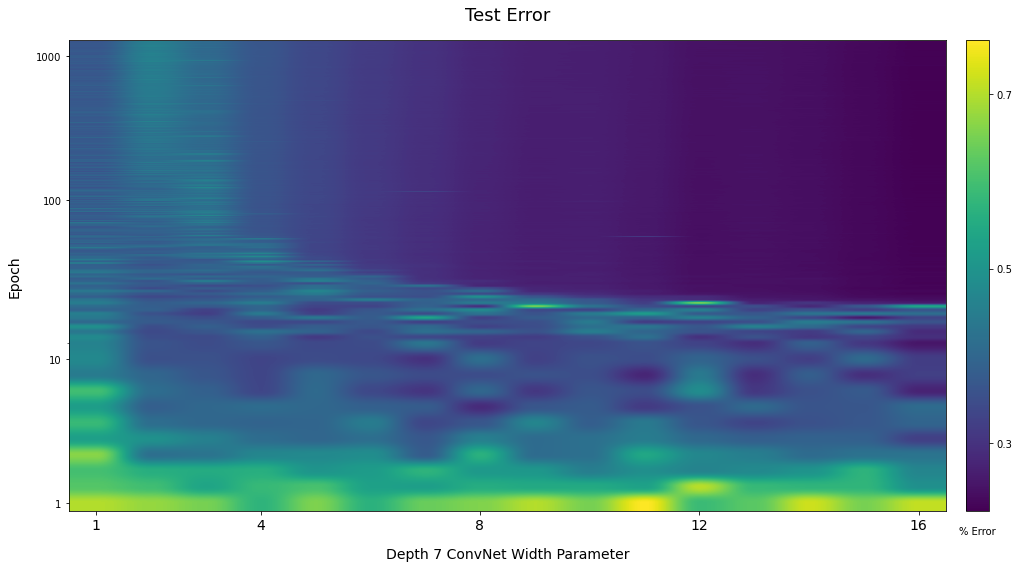

In [360]:
fig = plt.figure(figsize=(15, 8))
ax = fig.gca()

M = 1 - test_accuracy
norm = matplotlib.colors.Normalize(vmin=0.2, vmax=np.max(M))
im = ax.imshow(M.T, aspect='auto',  origin='lower', ) 

# set axis labels and title
ax.set_xlabel('Depth 7 ConvNet Width Parameter', fontsize=14, labelpad=15)
ax.set_ylabel('Epoch', fontsize=14, labelpad=15)
ax.set_title('Test Error', fontsize=18, pad=20)

# set x axis ticks (not that there is an offset of 1 since the array is 0 indexed)
x_idx = [0, 3, 7, 11, 15]
x_vals = x_idx
x_labs = ['%d' % (n+1) for n in x_idx]
ax.set_xticks(x_idx)
ax.set_xticklabels(x_labs, fontsize=14)

# set y ticks and adjust scale
ax.set_yscale('symlog', linthresh=10)
ax.set_yticks([i-1 for i in [1, 10, 100, 1000]])
ax.set_yticklabels([1, 10, 100, 1000])

# Colorbar
ticks = [0.2, 0.3, 0.5, 0.7]
cbar = fig.colorbar(im, pad=0.02, ticks=ticks, fraction=0.1)
cbar.ax.get_xaxis().labelpad = 15
cbar.ax.set_xlabel('% Error')

plt.tight_layout()
plt.show()